In [21]:
import numpy as np
import cv2
import tensorflow
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import glob , random

In [22]:
device = tensorflow.test.gpu_device_name()
device

'/device:GPU:0'

In [23]:
data_v = glob.glob("/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/*")
data_nv = glob.glob("/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/*")

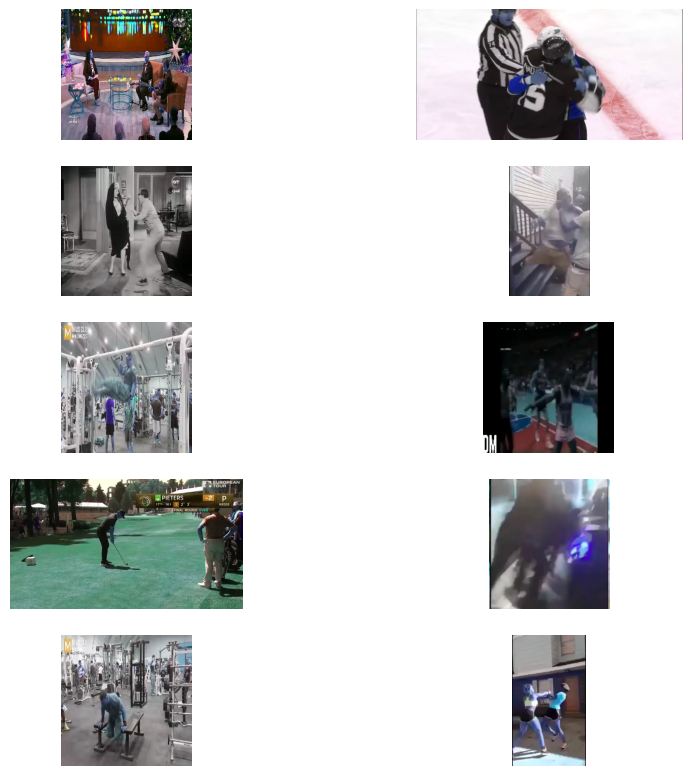

In [24]:
#visualize data  

plt.figure(figsize = (10  , 20))


for counter in range(1, 11) :
        
        vid_path = random.choice(data_v) if counter  %2 == 0  else random.choice(data_nv)
        
#         print(vid_path)
        video = cv2.VideoCapture(vid_path)
        
        ret , frame = video.read()
        
        if not ret :
            break
            
        plt.subplot(10 , 2 , counter ) 
#         frame = cv2.colorChange(frame , cv2.COLOR_BGR2RGB)
        plt.imshow(frame) 
        plt.axis("off")
        
        


In [25]:
#analyzing average frmes per second
fps_v = []
fps_nv = []
len(data_v) , len(data_nv)



(1000, 1000)

In [26]:
import math

SEQ_LEN = 20 
IMG_HEIGHT = 64 
IMG_WIDTH = 64
def get_frames(path):
    video = cv2.VideoCapture(path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_no = max(total_frames // SEQ_LEN, 1)
    
    frames_list = np.zeros((SEQ_LEN, IMG_HEIGHT, IMG_WIDTH, 3))  # Preallocate memory
    
    for i in range(SEQ_LEN):
        video.set(cv2.CAP_PROP_POS_FRAMES, i * frame_no)
        ret, frame = video.read()
        
        if not ret:
            break
        
        frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH)) / 255
        frames_list[i] = frame
    
    video.release()
    return frames_list if len(frames_list) == SEQ_LEN else None


In [27]:
f = get_frames(random.choice(data_v))
print(len(f) == SEQ_LEN , len(f))

True 20


In [28]:
def create_dataset( path ) :
    features = []
    labels = []
    paths = []
    
    for num , i in enumerate(path) :
        frames = get_frames(i)
        
        if len(frames) != SEQ_LEN :
            print(i)
            break
        if num % 500 == 0 and  num != 0: 
#             break
            print(num)
        features.append(frames)
        label = 0 if "NV_" in i else 1
        labels.append(label)
        paths.append(i)
        
        
    features = np.array(features)
    labels = np.array(labels)
    
    return features , labels , paths 
        

In [29]:
CLASSES_LIST = ["VIOLENCE" , "NONVIOLENCE"]
DATA_PATH = glob.glob("/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/*/*")
random.shuffle(DATA_PATH)

In [30]:
with tf.device(device) :
    features , labels , paths = create_dataset(DATA_PATH)

500
1000


[h264 @ 0x5b59aceed300] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5b59aceed300] error while decoding MB 98 31
[h264 @ 0x5b59aceed300] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5b59aceed300] error while decoding MB 98 31
[h264 @ 0x5b59aceed300] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5b59aceed300] error while decoding MB 98 31
[h264 @ 0x5b59aceed300] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5b59aceed300] error while decoding MB 98 31


1500


In [31]:
labels

array([1, 1, 0, ..., 0, 0, 1])

In [55]:
from sklearn.model_selection import train_test_split

with tf.device(device) :

    train_x , test_x , train_y , test_y = train_test_split(features , labels , test_size = .25 , 
                                                           shuffle = True , random_state = 33)



In [56]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''


    model = Sequential()
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'relu',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQ_LEN,
                                                                                      IMG_HEIGHT, IMG_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(1, activation = "sigmoid"))
    

    model.summary()

    return model

In [58]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def create_advanced_convlstm_model():
    '''
    This function constructs a more advanced ConvLSTM model, inspired by VGG-like architecture with regularization.
    Returns:
        model: The advanced ConvLSTM model.
    '''
    model = Sequential()

    # ConvLSTM Block 1
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='relu', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(1e-4),
                         input_shape=(SEQ_LEN, IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # ConvLSTM Block 2
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='relu', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # Conv Block 1 (VGG-like addition)
    model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Dropout(0.3)))

    # ConvLSTM Block 3
    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='relu', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # ConvLSTM Block 4
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='relu', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.4))  # Dropout before final layer for regularization
    model.add(Dense(1, activation="sigmoid"))  # Sigmoid for binary classification

    # Model Summary
    model.summary()

    return model


In [59]:
# Construct the required convlstm model.
with tf.device(device) :
    convlstm_model = create_advanced_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_16 (ConvLSTM2D)     │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 62, 62, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_16 (MaxPooling3D) │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_17 (ConvLSTM2D)     │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 29, 29, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_17 (MaxPooling3D) │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 15, 15, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 20, 8, 8, 16)   │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 20, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_18 (ConvLSTM2D)     │ (None, 20, 6, 6, 14)   │        15,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 6, 6, 14)   │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 20, 3, 3, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 20, 3, 3, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_19 (ConvLSTM2D)     │ (None, 20, 1, 1, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 1, 1, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_19 (MaxPooling3D) │ (None, 20, 1, 1, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 59,041 (230.63 KB)

 Trainable params: 58,925 (230.18 KB)

 Non-trainable params: 116 (464.00 B)

Model Created Successfully!


In [60]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

with tf.device(device):   
    # Create an Instance of Early Stopping Callback
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Create a Learning Rate Reducer Callback
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')

    # Compile the model
    convlstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    convlstm_model_training_history = convlstm_model.fit(
        x=train_x, 
        y=train_y, 
        epochs=50, 
        batch_size=4,
        shuffle=True, 
        validation_split=0.2, 
        callbacks=[early_stopping_callback, reduce_lr_callback]
    )


Epoch 1/50


I0000 00:00:1726583175.507786     153 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion', 112 bytes spill stores, 112 bytes spill loads



300/300 ━━━━━━━━━━━━━━━━━━━━ 285s 56ms/step - accuracy: 0.5480 - loss: 0.8800 - val_accuracy: 0.5233 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6214 - loss: 0.6781 - val_accuracy: 0.6133 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6432 - loss: 0.6701 - val_accuracy: 0.6933 - val_loss: 0.7234 - learning_rate: 0.0010
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6525 - loss: 0.6311 - val_accuracy: 0.6600 - val_loss: 0.6499 - learning_rate: 0.0010
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.7413 - loss: 0.5813 - val_accuracy: 0.7300 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.7333 - loss: 0.5608 - val_accuracy: 0.7133 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7536 - loss: 0.536

In [61]:
model_evaluation_history = convlstm_model.evaluate(test_x, test_y)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.8965 - loss: 0.3206


In [63]:
import datetime as dt
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

print(model_evaluation_loss , model_evaluation_accuracy)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

0.3518313765525818 0.871999979019165


In [41]:
print(tf.__version__)
    

2.16.1
